<a href="https://colab.research.google.com/github/amfei/XAI-Explainer-Models/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install catboost
!pip install shap

import warnings

# Suppress warnings
warnings.filterwarnings('ignore')


import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import xgboost
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

import shap
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, f1_score, recall_score

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"


df = pd.read_csv(url, na_values=' ?', skipinitialspace=True)


df= df [['39','State-gov',	'Bachelors',	'13'	,'Never-married',	'Adm-clerical',	'Not-in-family',	'White',	'Male',	'40'	,'United-States',	'<=50K']]


df.columns =  ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country', 'Target']
# Drop rows with missing values
df.dropna(inplace=True)
df = df[['age'	,	'education-num'	,	'occupation'	,'relationship'	,	'sex'	,'hours-per-week', 'Target']	].copy()

In [6]:
df.describe()

,age,education-num,hours-per-week
count,32560.000000,32560.000000,32560.000000
mean,38.581634,10.080590,40.437469
std,13.640642,2.572709,12.347618
min,17.000000,1.000000,1.000000
25%,28.000000,9.000000,40.000000
50%,37.000000,10.000000,40.000000
75%,48.000000,12.000000,45.000000
max,90.000000,16.000000,99.000000


In [7]:
df.dtypes

,0
age,int64
education-num,int64
occupation,object
relationship,object
sex,object
hours-per-week,int64
Target,object


In [8]:
print(f"Number of unique values:\n{df.nunique()}")

Number of unique values:
age               73
education-num     16
occupation        15
relationship       6
sex                2
hours-per-week    94
Target             2
dtype: int64


In [9]:
print("Unique values in each categorical column:")
for col in df.select_dtypes(include = [object]):
    print(col, ":", df[col].unique())

Unique values in each categorical column:
occupation : ['Exec-managerial' 'Handlers-cleaners' 'Prof-specialty' 'Other-service'
 'Adm-clerical' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship : ['Husband' 'Not-in-family' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
sex : ['Male' 'Female']
Target : ['<=50K' '>50K']


In [10]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="age",y="education-num", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="age",y="hours-per-week", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="education-num",y="hours-per-week", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

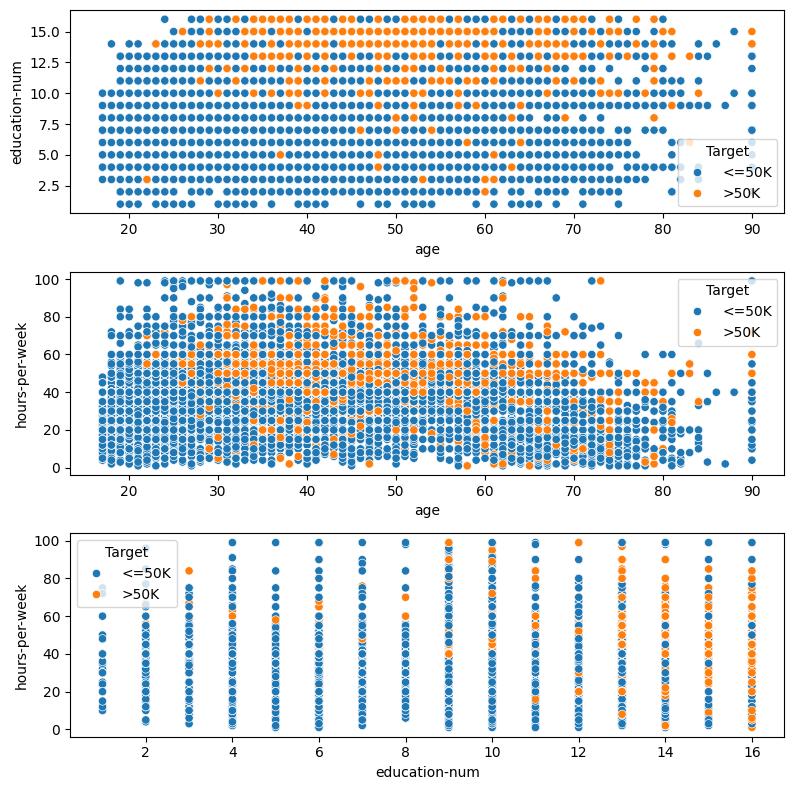

In [11]:
scatters(df, h="Target")

In [12]:
def bar_plot(variable):
    """
        input: variable ex: "Sex"
        output: bar plot & value count
    """
    # get feature
    var = df[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()

    # visualize
    plt.figure(figsize = (15,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Fraquency")
    plt.title(variable)
    plt.xticks(rotation=45)
    plt.show()
    print("{}: \n{}".format(variable,varValue))


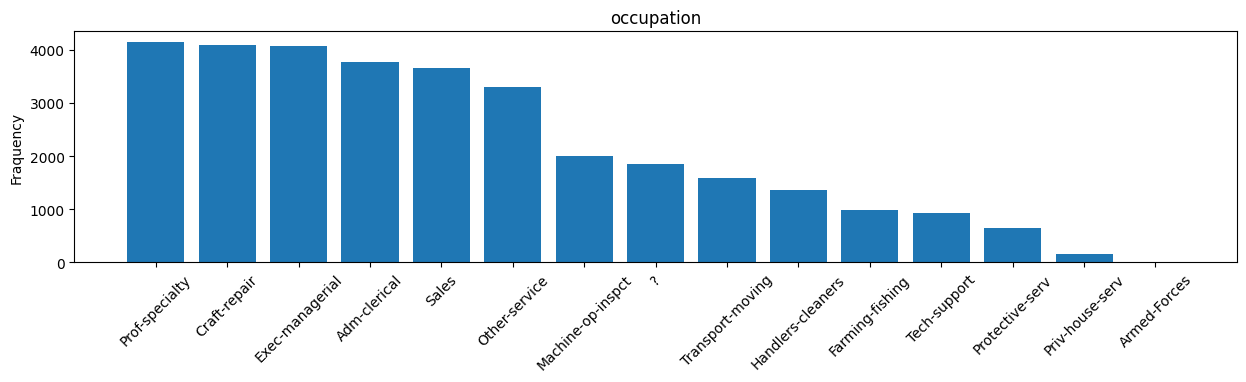

occupation: 
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3769
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64


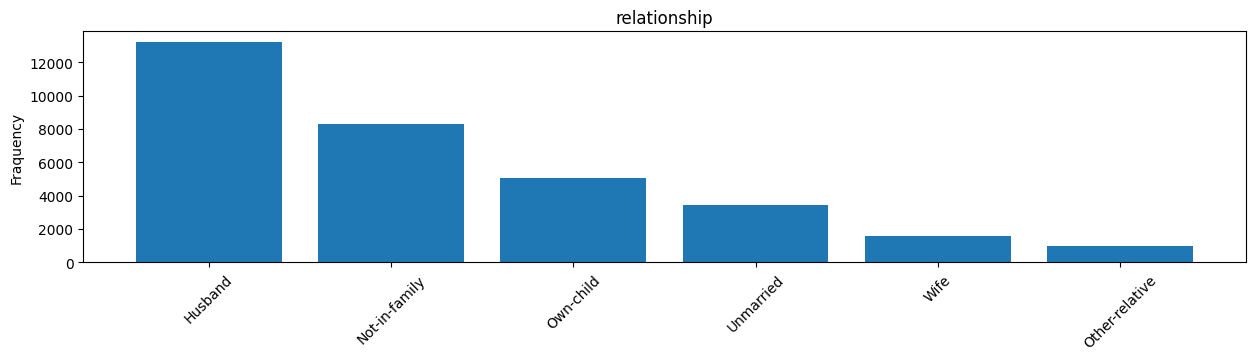

relationship: 
relationship
Husband           13193
Not-in-family      8304
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: count, dtype: int64


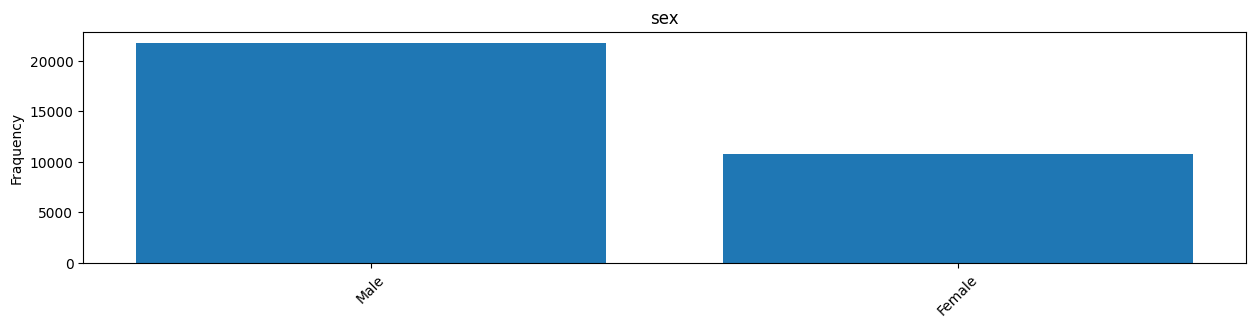

sex: 
sex
Male      21789
Female    10771
Name: count, dtype: int64


In [13]:
category1 = ['occupation'	,'relationship','sex'  ]
for c in category1:
    bar_plot(c)


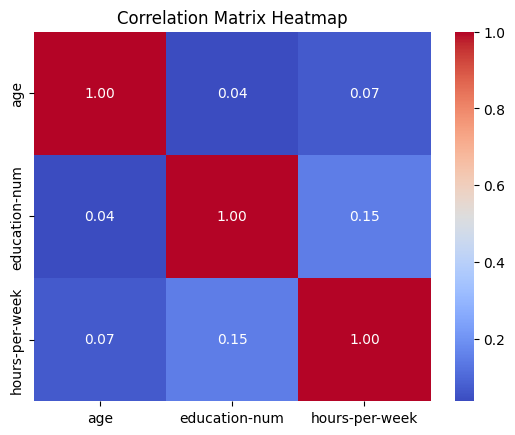

In [14]:
# 1. Correlation Matrix
correlation_matrix = df[['age',	'education-num',	'hours-per-week']].corr()

# 2. Heatmap of Correlation Matrix

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [15]:
df["Target"].value_counts()

,count
Target,
<=50K,24719
>50K,7841


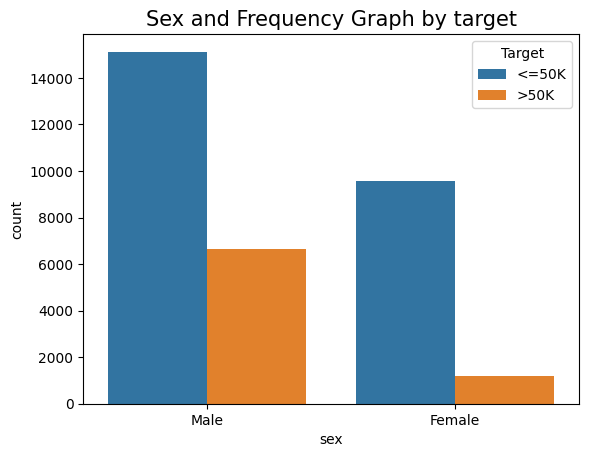

In [16]:
sns.countplot(x ="sex", hue="Target", data = df).set_title("Sex and Frequency Graph by target", fontsize=15);
plt.show()

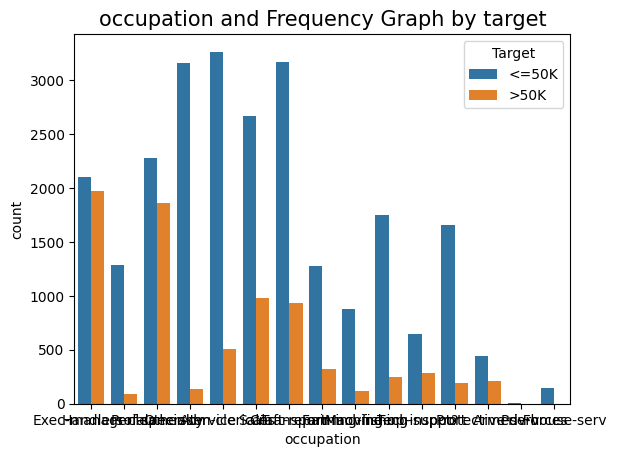

In [17]:
sns.countplot(x ="occupation", hue="Target", data = df).set_title("occupation and Frequency Graph by target", fontsize=15);
plt.show()

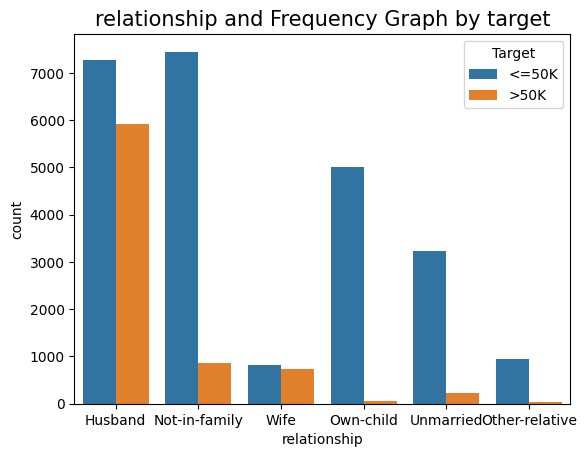

In [18]:
sns.countplot(x ="relationship", hue="Target", data = df).set_title("relationship and Frequency Graph by target", fontsize=15);
plt.show()

In [19]:
df.isnull().sum()

,0
age,0
education-num,0
occupation,0
relationship,0
sex,0
hours-per-week,0
Target,0


In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   education-num   32560 non-null  int64 
 2   occupation      32560 non-null  object
 3   relationship    32560 non-null  object
 4   sex             32560 non-null  object
 5   hours-per-week  32560 non-null  int64 
 6   Target          32560 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.7+ MB


In [21]:
# Label Encoding
columns_label = ["sex","Target"]
labelencoder = LabelEncoder()
for i in columns_label:
    df[i] = labelencoder.fit_transform(df[i])

In [22]:
# Get Dummies
columns_dummy = ['occupation'	,'relationship']
for i in columns_dummy:
    df = pd.concat([df, pd.get_dummies(df[i])], axis=1)

df

,age,education-num,occupation,relationship,sex,hours-per-week,Target,?,Adm-clerical,Armed-Forces,...,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,50,13,Exec-managerial,Husband,1,13,0,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,38,9,Handlers-cleaners,Not-in-family,1,40,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,53,7,Handlers-cleaners,Husband,1,40,0,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,28,13,Prof-specialty,Wife,0,40,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,37,14,Exec-managerial,Wife,0,40,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,12,Tech-support,Wife,0,38,0,False,False,False,...,False,False,True,False,False,False,False,False,False,True
32556,40,9,Machine-op-inspct,Husband,1,40,1,False,False,False,...,False,False,False,False,True,False,False,False,False,False
32557,58,9,Adm-clerical,Unmarried,0,40,0,False,True,False,...,False,False,False,False,False,False,False,False,True,False
32558,22,9,Adm-clerical,Own-child,1,20,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [23]:
df.drop(['occupation'	,'relationship', '?'], axis = 1, inplace=True)

In [24]:
df = df.astype(int)
df

,age,education-num,sex,hours-per-week,Target,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,...,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,50,13,1,13,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,38,9,1,40,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,53,7,1,40,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,28,13,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,37,14,0,40,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,12,0,38,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
32556,40,9,1,40,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
32557,58,9,0,40,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32558,22,9,1,20,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
#Splitting the data
y = df.Target
X = df.drop("Target", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [26]:
# from imblearn.over_sampling import SMOTE
# # Apply SMOTE to the training set
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)


In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.fit_transform(X_test)
X_train1 = pd.DataFrame(X_train1, columns = X_train.columns)
X_train1

,age,education-num,sex,hours-per-week,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,...,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,-1.359186,-0.807045,0.700480,-0.036590,-0.359761,-0.017528,-0.378362,-0.379025,-0.179491,-0.209881,...,-0.142583,-0.355185,-0.171234,-0.227145,-0.826841,-0.585212,-0.175812,2.326501,-0.345098,-0.220812
1,-1.285973,-0.027011,-1.427593,-2.302194,2.779622,-0.017528,-0.378362,-0.379025,-0.179491,-0.209881,...,-0.142583,-0.355185,-0.171234,-0.227145,-0.826841,-0.585212,-0.175812,2.326501,-0.345098,-0.220812
2,1.862188,-0.027011,-1.427593,-3.030424,-0.359761,-0.017528,-0.378362,2.638348,-0.179491,-0.209881,...,-0.142583,-0.355185,-0.171234,-0.227145,-0.826841,1.708783,-0.175812,-0.429830,-0.345098,-0.220812
3,-0.919908,-0.417028,0.700480,-0.036590,-0.359761,-0.017528,-0.378362,-0.379025,-0.179491,-0.209881,...,-0.142583,-0.355185,5.839959,-0.227145,-0.826841,-0.585212,5.687892,-0.429830,-0.345098,-0.220812
4,-1.285973,0.363005,0.700480,0.448897,-0.359761,-0.017528,-0.378362,-0.379025,5.571298,-0.209881,...,-0.142583,-0.355185,-0.171234,-0.227145,1.209422,-0.585212,-0.175812,-0.429830,-0.345098,-0.220812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,-0.260990,1.143039,-1.427593,0.367982,-0.359761,-0.017528,-0.378362,-0.379025,-0.179491,-0.209881,...,-0.142583,2.815433,-0.171234,-0.227145,-0.826841,1.708783,-0.175812,-0.429830,-0.345098,-0.220812
26044,-0.553842,-0.417028,-1.427593,1.177127,-0.359761,-0.017528,-0.378362,-0.379025,-0.179491,-0.209881,...,-0.142583,-0.355185,-0.171234,-0.227145,-0.826841,-0.585212,-0.175812,-0.429830,-0.345098,4.528741
26045,0.324714,-0.417028,0.700480,-0.036590,-0.359761,-0.017528,-0.378362,-0.379025,5.571298,-0.209881,...,-0.142583,-0.355185,-0.171234,-0.227145,1.209422,-0.585212,-0.175812,-0.429830,-0.345098,-0.220812
26046,-1.285973,-0.417028,-1.427593,-0.845734,-0.359761,-0.017528,-0.378362,-0.379025,-0.179491,-0.209881,...,-0.142583,-0.355185,-0.171234,-0.227145,-0.826841,1.708783,-0.175812,-0.429830,-0.345098,-0.220812


In [28]:

xgb = XGBClassifier(learning_rate = 0.05, max_depth = 5,n_estimators=100,subsample=0.8 )
xgb.fit(X_train1,y_train)
y_pred_xgb = xgb.predict(X_test1)
score_xgb = accuracy_score(y_test, y_pred_xgb)
f1_score_xgb = f1_score(y_test, y_pred_xgb)
recall_score_xgb = recall_score(y_test, y_pred_xgb)
print("Accuracy Score:", score_xgb)
print("F-1 Score:", f1_score_xgb)
print("Recall Score:", recall_score_xgb)

Accuracy Score: 0.8135749385749386
F-1 Score: 0.47217391304347817
Recall Score: 0.339375


In [29]:


lgbm = LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8)
lgbm.fit(X_train1, y_train)
y_pred_lgbm = lgbm.predict(X_test1)
score_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_score_lgbm = f1_score(y_test, y_pred_lgbm)
recall_score_lgbm = recall_score(y_test, y_pred_lgbm)
print("Accuracy Score:", score_lgbm)
print("F-1 Score:", f1_score_lgbm)
print("Recall Score:", recall_score_lgbm)


[LightGBM] [Info] Number of positive: 6241, number of negative: 19807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239596 -> initscore=-1.154895
[LightGBM] [Info] Start training from score -1.154895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [30]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train1, y_train)
y_pred_ada = adaboost.predict(X_test1)
score_ada = accuracy_score(y_test, y_pred_ada)
f1_score_ada = f1_score(y_test, y_pred_ada)
recall_score_ada = recall_score(y_test, y_pred_ada)
print("Accuracy Score:", score_ada)
print("F-1 Score:", f1_score_ada)
print("Recall Score:", recall_score_ada)

Accuracy Score: 0.8379914004914005
F-1 Score: 0.6353266505357759
Recall Score: 0.574375


In [31]:
catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42)
catboost.fit(X_train1, y_train, verbose=False)
y_pred_cat = catboost.predict(X_test1)
score_cat = accuracy_score(y_test, y_pred_cat)
f1_score_cat = f1_score(y_test, y_pred_cat)
recall_score_cat = recall_score(y_test, y_pred_cat)
print("Accuracy Score:", score_cat)
print("F-1 Score:", f1_score_cat)
print("Recall Score:", recall_score_cat)

Accuracy Score: 0.8367628992628993
F-1 Score: 0.6358341897910242
Recall Score: 0.58


In [32]:
from sklearn.ensemble import HistGradientBoostingClassifier
hist_gradient_boost = HistGradientBoostingClassifier(learning_rate=0.1, random_state=42)
hist_gradient_boost.fit(X_train1, y_train)
y_pred_hist = hist_gradient_boost.predict(X_test1)
score_hist = accuracy_score(y_test, y_pred_hist)
f1_score_hist = f1_score(y_test, y_pred_hist)
recall_score_hist = recall_score(y_test, y_pred_hist)
print("Accuracy Score:", score_hist)
print("F-1 Score:", f1_score_hist)
print("Recall Score:", recall_score_hist)

Accuracy Score: 0.8376842751842751
F-1 Score: 0.6480186480186481
Recall Score: 0.608125


In [33]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train1, y_train)
y_pred = model_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred)


print("Accuracy:", acc_rf)



Accuracy: 0.5546683046683046


In [34]:
#Sorting by accuracy score
models = pd.DataFrame({'Models':['LGBM Boost Model','XGBoost Model',
                                 'AdaBoost Model', 'CatBoost Model', 'HistGradientBoost Model'],
                      'Score':[score_lgbm, score_xgb, score_ada, score_cat, score_hist]})
models.sort_values(by='Score', ascending = False)

,Models,Score
0,LGBM Boost Model,0.839220
2,AdaBoost Model,0.837991
4,HistGradientBoost Model,0.837684
3,CatBoost Model,0.836763
1,XGBoost Model,0.813575


In [35]:
#Sorting by f-1 score
models = pd.DataFrame({'Models':['LGBM Boost Model','XGBoost Model',
                                 'AdaBoost Model', 'CatBoost Model', 'HistGradientBoost Model'],
                      'Score':[f1_score_lgbm, f1_score_xgb, f1_score_ada, f1_score_cat, f1_score_hist]})
models.sort_values(by='Score', ascending = False)

,Models,Score
4,HistGradientBoost Model,0.648019
0,LGBM Boost Model,0.636079
3,CatBoost Model,0.635834
2,AdaBoost Model,0.635327
1,XGBoost Model,0.472174


In [36]:
#Sorting by recall score
models = pd.DataFrame({'Models':['LGBM Boost Model','XGBoost Model',
                                 'AdaBoost Model', 'CatBoost Model', 'HistGradientBoost Model'],
                      'Score':[recall_score_lgbm, recall_score_xgb, recall_score_ada, recall_score_cat, recall_score_hist]})
models.sort_values(by='Score', ascending = False)


,Models,Score
4,HistGradientBoost Model,0.608125
3,CatBoost Model,0.580000
2,AdaBoost Model,0.574375
0,LGBM Boost Model,0.571875
1,XGBoost Model,0.339375


In [37]:
# compute SHAP values
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

 99%|===================| 25757/26048 [00:41<00:00]       

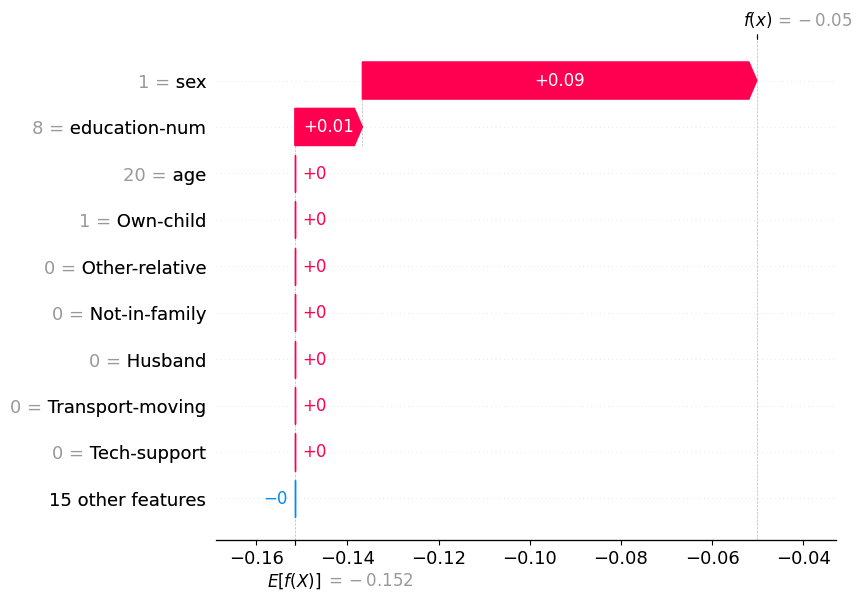

In [38]:
shap.plots.waterfall(shap_values[0])

In [41]:
shap.initjs()
explanation = explainer(X_train)
shap.plots.force(explanation[0:5], plot_cmap="DrDb")

 99%|===================| 25896/26048 [00:53<00:00]       

In [42]:
shap.initjs()
display(shap.plots.force(explanation[0], plot_cmap='RdBu'))

In [43]:
#!pip install lime
import lime
from lime.lime_tabular import LimeTabularExplainer


In [44]:
explainer = LimeTabularExplainer(X_train1.values, mode="classification", feature_names=X_train1.columns, random_state=42)

In [45]:
i = 1
observation = X_test.iloc[i]
print(observation)
print("class: ", y_test.iloc[i])

age                  45
education-num         9
sex                   0
hours-per-week       40
Adm-clerical          0
Armed-Forces          0
Craft-repair          0
Exec-managerial       1
Farming-fishing       0
Handlers-cleaners     0
Machine-op-inspct     0
Other-service         0
Priv-house-serv       0
Prof-specialty        0
Protective-serv       0
Sales                 0
Tech-support          0
Transport-moving      0
Husband               0
Not-in-family         0
Other-relative        0
Own-child             0
Unmarried             0
Wife                  1
Name: 27047, dtype: int64
class:  0


In [46]:
explanation = explainer.explain_instance(observation, lgbm.predict_proba)


In [47]:
explanation.show_in_notebook()

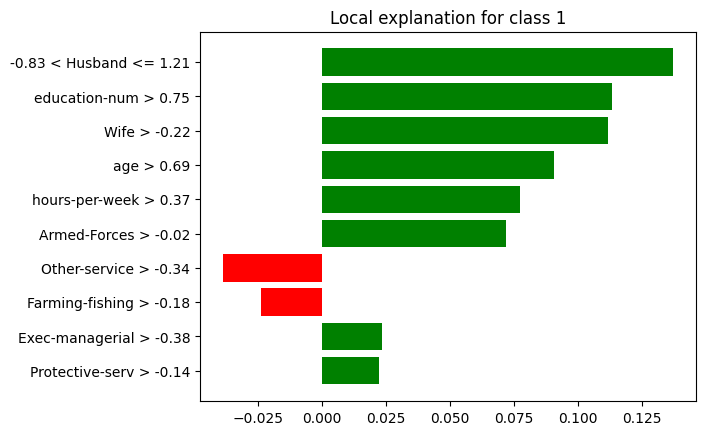

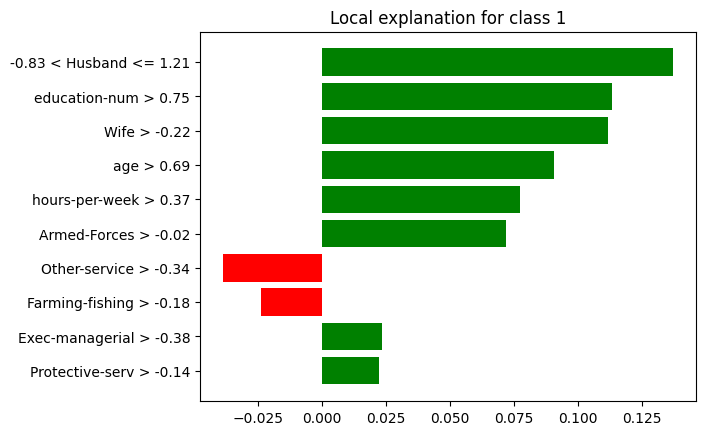

In [48]:
explanation.as_pyplot_figure()


The bar plot shows the mean predictions for males and females. A significant difference between these bars could indicate bias in the model, meaning it might be favoring one gender over the other in its predictions.

1. Understanding SHAP Values:
SHAP values indicate the contribution of each feature to the prediction made by the model.
A SHAP value close to zero suggests that the feature has little impact on the prediction, while a high absolute SHAP value (positive or negative) indicates a significant impact.
2. Color Representation:
The colors represent the feature values: **red indicates a high value** for that feature, and blue indicates a low value.
For example, in the case of age, **red would correspond to older individuals** and blue to younger individuals.
3. X-axis (SHAP Value Impact):
The X-axis represents the SHAP values, which show the direction and magnitude of impact:
**Positive SHAP values** mean the feature increases the model's prediction (e.g., increases the likelihood of a certain class being predicted).
Negative SHAP values mean the feature decreases the model's prediction.
4. Y-axis (Features):
The features are listed on the Y-axis in order of importance, from top to bottom. The most influential features appear at the top.
5. Feature Analysis:
Marital-Status: High values (possibly indicating married individuals) push the model output in a positive direction, meaning they likely increase the model’s prediction towards a certain outcome.
Education-Num: Both high and low values significantly affect the prediction. The variation suggests that different education levels have varying impacts on the model's predictions.
Relationship: High values (possibly signifying a strong or specific type of relationship) can either increase or decrease the prediction, indicating nuanced effects based on relationship type.
Age: **Older individuals** (red points) seem to **push the prediction positively**, while younger individuals (blue points) have the opposite effect.
Sex: High values (possibly indicating male) generally push the prediction positively.
6. General Observations:
Features like **marital-status, education-num, and relationship** have a broader spread of SHAP values, suggesting they are key drivers of the model's predictions.
The vertical width of each point cloud represents how much variability exists in SHAP values for different feature values, indicating feature interaction or non-linearity.
7. Importance of the Plot:
This plot provides a holistic view of how each feature contributes to the model's predictions, allowing one to identify the most important features and understand their effects.
It can be used for model interpretability and for debugging, to see if the model is relying on certain features in an expected or unexpected way.
In summary, this SHAP value plot helps to justify which features are most influential in the model's predictions and how their values affect those predictions.

In [4]:
# Get feature importances
importances = xgb.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df

NameError: name 'xgb' is not defined